# **Estimando a Arrecadação da Dívida Ativa da União com Machine Learning: Uma análise aplicada sobre os dados de arrecadação no período de 2015 a 2021.**


**ESCLARECIMENTO**

O presente notebook procura avaliar se é possível, por meio da utilização de modelos de Machine Learn, aprimorar as estimativas de arrecadação da Dívida Ativa da União elaboradas pela Procuradoria-Geral da Fazenda Nacional.

Trata-se de documento integrante de artigo acadêmico homônimo, submetido para publicação na Revista da CGU (ISSN 2595-668X), para o dossiê especial sobre Ciência de Dados na Administração Pública. https://revista.cgu.gov.br/Revista_da_CGU.

As informações de arrecadação, bem como dos parcelamentos e transações tributárias, foram obidos junto à Procuradoria-Geral da Fazenda Nacional, por meio da Lei de Acesso à Informação, pedido nº. 03005.291447/2022-40, disponível para consulta no seguinte endereço: http://www.consultaesic.cgu.gov.br/busca/dados/Lists/Pedido/Item/displayifs.aspx?List=0c839f31%2D47d7%2D4485%2Dab65%2Dab0cee9cf8fe&ID=1637685&Source=http%3A%2F%2Fwww%2Econsultaesic%2Ecgu%2Egov%2Ebr%2Fbusca%2FSitePages%2Fresultadopesquisa%2Easpx%3Fk%3D03005%252E291447%252F2022%252D40&Web=88cc5f44%2D8cfe%2D4964%2D8ff4%2D376b5ebb3bef.

Os indicadores macroeconômicos podem ser encontrados no site do Banco Central do Brasil, na ferramenta *Sistema Gerenciador de Séries Temporais* – SGS (https://www3.bcb.gov.br/sgspub/). Especificamente, foram capturadas as planilhas de códigos: “4380 - PIB mensal - Valores correntes (R$ milhões) – Função: Variação Percentual”; “13522 - Índice nacional de preços ao consumidor - amplo (IPCA) - em 12 meses – Função: Linear”; “4189 - Taxa de juros - Selic acumulada no mês anualizada base 252 - % a.a. – Função: Linear”; “3698 - Taxa de câmbio - Livre - Dólar americano (venda) - Média de período – mensal - Função: Linear”; e “189 - Índice geral de preços do mercado (IGP-M) - Var. % mensal – Função: Linear”.

Este notebook apresenta somente os códigos desenvolvidos em liguagem python para tratamento e exploração dos dados, bem como treinamento e avaliação dos modelos de aprendizado de máquina. Comentários e explicações sobre os achados e as decisões relacionados aos dados estão disponível apenas no texto do artigo acadêmico.


---


**PREPARAÇÃO DO SET UP**

In [1]:
#IMPORTANTO BIBLIOTECAS PYTHON

#Bibliotecas de manipulação de dados:
import pandas as pd
import numpy as np
import datetime as dt

#Bibliotecas para criação de gráficos:
import seaborn as sns
import matplotlib.pyplot as plt

#Bibliotecas de Machine Learning:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
#CARREGANDO AS BASES DE DADOS

#Arrecadação mensal de janeiro de 2015 a dezembro de 2021
arrecad_15_21 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/'+ \
                              'Public_DAU/PESQUISA_DIVIDA_ATIVA_DA_UNIAO'+ \
                              '___SIC_03005.291447.2022_40.xlsx')

#Parcelamentos e Transações disponíveis de janeiro de 2015 a dezembro de 2021
parc_trans = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/'+ \
                           'Public_DAU/parcelamentos_transacoes.xlsx')

#PIB variação mensal de janeiro de 2015 a dezembro de 2021
pib = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Public_DAU/'+ \
                  'STP-20220627160908699.csv', sep=';', encoding='latin-1')

#IPCA mensal de janeiro de 2015 a dezembro de 2021 anualizado
ipca = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Public_DAU/'+ \
                   'STP-20220627164346259.csv', sep=';', encoding='latin-1')

#SELIC mensal de janeiro de 2015 a dezembro de 2021
selic = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Public_DAU/'+ \
                    'STP-20220627170255085.csv', sep=';', encoding='latin-1')

#Câmbio mensal de janeiro de 2015 a dezembro de 2021
cambio = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Public_DAU/'+ \
                     'STP-20220627172312090.csv', sep=';', encoding='latin-1')

#IGP-M mensal de janeiro de 2015 a dezembro de 2021
igpm = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Public_DAU/'+ \
                   'STP-20220627173251822.csv', sep=';', encoding='latin-1')




---

**TRATAMENTO DOS DADOS**

In [3]:
#TRATANDO ARQUIVO DA ARRECADAÇÃO
#File: PESQUISA_DIVIDA_ATIVA_DA_UNIAO___SIC_03005.291447.2022_40.xlsx

#Excluindo os títulos
arrecad_15_21 = arrecad_15_21.drop([0, 1], axis=0)

#Renomeando as colunas de dados
arrecad_15_21.rename(columns={
    'PESQUISA DÍVIDA ATIVA DA UNIÃO - SIC 03005.291447/2022-40': 'DATA',
    'Unnamed: 1': 'VALOR'}, inplace=True)

#Convertendo a coluna DATA para o tipo data
arrecad_15_21['DATA'] = pd.to_datetime(arrecad_15_21['DATA'], format="%m/%Y")

#Transformando a coluna DATA no índice da tabela
arrecad_15_21.set_index('DATA', inplace=True)

#Convertendo os dados da coluna VALOR para o tipo numérico ponto flutuante
arrecad_15_21['VALOR'] = arrecad_15_21['VALOR'].astype('float')

#Setando a forma de apresenta dos dados em formato float para evitar o uso da 
#notação científica
pd.set_option('display.float_format', '{:.3f}'.format)

#Exibindo as 5 primeiras linhas para verificação
arrecad_15_21.head()

,VALOR
DATA,
2015-01-01,1226158509.920
2015-02-01,1086542602.050
2015-03-01,1184527440.290
2015-04-01,1079880695.580
2015-05-01,1317084542.610


In [4]:
#TRATANDO ARQUIVO DOS PARCELAMENTOS E TRANSAÇÕES
#File: parcelamentos_transacoes.xlsx

#Convertendo a coluna DATA para o formato data
parc_trans['DATA'] = pd.to_datetime(parc_trans['DATA'], errors='raise')

#Setando a coluna DATA como índice do dataframe
parc_trans.set_index("DATA", inplace=True)

#Encontranto as colunas dos parcelamentos e transações que possuem dados
col_par_tran = []
for i in range(parc_trans.mean().count()):
  if parc_trans.mean()[i] > 0:
    col_par_tran.append(parc_trans.mean().index[i])

#Criando DataFrame apenas com as colunas que possuem dados
data_parc_trans = parc_trans[col_par_tran]

#Exibindo as 5 primeiras linhas para verificação
data_parc_trans.head()

,P-S-A,P-S-B,P-S-O,P-S-P,P-S-R,P-G-SN,P-G-A,T-G-A,T-G-SN,T-G-PV,T-S-A,T-S-R
DATA,,,,,,,,,,,,
2015-01-01,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2015-02-01,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2015-03-01,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2015-04-01,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2015-05-01,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [5]:
#TRATANDO ARQUIVO DO PIB 
#File: STP-20220627160908699.csv

#Renomeando as colunas de dados
pib.rename(columns={"Data": "DATA",
                     "4380 - PIB mensal - Valores correntes (R$ milhões) -"+ \
                    " Variação Percentual": "PIB"},
            inplace=True)

#Excluindo a linha com informação da fonte dos dados
pib.drop(pib.index[84], inplace=True)

#Convertendo a coluna DATA para o tipo data
pib['DATA'] = pd.to_datetime(pib['DATA'], errors='raise')

#Transformando a coluna DATA no índice da tabela
pib.set_index('DATA', inplace=True)

#Convertendo os dados da coluna PIB para o tipo numérico ponto flutuante
pib["PIB"] = pib["PIB"].apply(lambda i: i.replace(",", "."))
pib["PIB"] = pib["PIB"].astype("float")

#Exibindo as 5 primeiras linhas para verificação
pib.head()

,PIB
DATA,
2015-01-01,-5.300
2015-02-01,-1.600
2015-03-01,10.400
2015-04-01,-3.600
2015-05-01,-1.000


In [6]:
#TRATANDO ARQUIVO DO IPCA 
#File: STP-20220627164346259.csv

#Renomeando as colunas de dados
ipca.rename(columns={"Data": "DATA",
                     "13522 - Índice nacional de preços ao consumidor -" + \
                     " amplo (IPCA) - em 12 meses - %": "IPCA"}, 
            inplace=True)

#Excluindo a linha com informação da fonte dos dados
ipca.drop(ipca.index[84], inplace=True)

#Convertendo a coluna DATA para o tipo data
ipca['DATA'] = pd.to_datetime(ipca['DATA'], errors='raise')

#Transformando a coluna DATA no índice da tabela
ipca.set_index('DATA', inplace=True)

#Convertendo os dados da coluna IPCA para o tipo numérico ponto flutuante
ipca["IPCA"] = ipca["IPCA"].apply(lambda i: i.replace(",", "."))
ipca["IPCA"] = ipca["IPCA"].astype("float")

#Exibindo as 5 primeiras linhas para verificação
ipca.head()

,IPCA
DATA,
2015-01-01,7.140
2015-02-01,7.700
2015-03-01,8.130
2015-04-01,8.170
2015-05-01,8.470


In [7]:
#TRATANDO ARQUIVO DA SELIC
#File: STP-20220627170255085.csv

#Renomeando as colunas de dados
selic.rename(columns={"Data": "DATA",
                     "4189 - Taxa de juros - Selic acumulada no mês "+ \
                     "anualizada base 252 - % a.a.": "SELIC"},
            inplace=True)

#Excluindo a linha com informação da fonte dos dados
selic.drop(selic.index[84], inplace=True)

#Convertendo a coluna DATA para o tipo data
selic['DATA'] = pd.to_datetime(selic['DATA'], errors='raise')

#Transformando a coluna DATA no índice da tabela
selic.set_index('DATA', inplace=True)

#Convertendo os dados da coluna SELIC para o tipo numérico ponto flutuante
selic["SELIC"] = selic["SELIC"].apply(lambda i: i.replace(",", "."))
selic["SELIC"] = selic["SELIC"].astype("float")

#Exibindo as 5 primeiras linhas para verificação
selic.head()

,SELIC
DATA,
2015-01-01,11.820
2015-02-01,12.150
2015-03-01,12.580
2015-04-01,12.680
2015-05-01,13.150


In [8]:
#TRATANDO ARQUIVO DO CÂMBIO
#File: STP-20220627172312090.csv

#Renomeando as colunas de dados
cambio.rename(columns={"Data": "DATA",
                     "3698 - Taxa de câmbio - Livre - Dólar americano (venda"+ \
                     ") - Média de período - mensal - u.m.c./US$": "CAMBIO"},
            inplace=True)

#Excluindo a linha com informação da fonte dos dados
cambio.drop(cambio.index[84], inplace=True)

#Convertendo a coluna DATA para o tipo data
cambio['DATA'] = pd.to_datetime(cambio['DATA'], errors='raise')

#Transformando a coluna DATA no índice da tabela
cambio.set_index('DATA', inplace=True)

#Convertendo os dados da coluna CAMBIO para o tipo numérico ponto flutuante
cambio["CAMBIO"] = cambio["CAMBIO"].apply(lambda i: i.replace(",", "."))
cambio["CAMBIO"] = cambio["CAMBIO"].astype("float")

#Exibindo as 5 primeiras linhas para verificação
cambio.head()

,CAMBIO
DATA,
2015-01-01,2.634
2015-02-01,2.817
2015-03-01,3.139
2015-04-01,3.043
2015-05-01,3.062


In [9]:
#TRATANDO ARQUIVO DO IGP-M
#File: STP-20220627173251822.csv

#Renomeando as colunas de dados
igpm.rename(columns={"Data": "DATA",
                     "189 - Índice geral de preços do mercado (IGP-M) - "+ \
                     "Var. % mensal": "IGPM"},
            inplace=True)

#Excluindo a linha com informação da fonte dos dados
igpm.drop(igpm.index[84], inplace=True)

#Convertendo a coluna DATA para o tipo data
igpm['DATA'] = pd.to_datetime(igpm['DATA'], errors='raise')

#Transformando a coluna DATA no índice da tabela
igpm.set_index('DATA', inplace=True)

#Convertendo os dados da coluna IGPM para o tipo numérico ponto flutuante
igpm["IGPM"] = igpm["IGPM"].apply(lambda i: i.replace(",", "."))
igpm["IGPM"] = igpm["IGPM"].astype("float")

#Exibindo as 5 primeiras linhas para verificação
igpm.head()

,IGPM
DATA,
2015-01-01,0.760
2015-02-01,0.270
2015-03-01,0.980
2015-04-01,1.170
2015-05-01,0.410


In [10]:
#ORGANIZANDO AS VARIÁVEIS MACROECONÔMICAS EM UM DATAFRAME
varmacro = pd.DataFrame()
varmacro['PIB'] = pib['PIB']
varmacro['IPCA'] = ipca['IPCA']
varmacro['SELIC'] = selic['SELIC']
varmacro['CAMBIO'] = cambio['CAMBIO']
varmacro['IGPM'] = igpm['IGPM']

#Exibindo as 5 primeiras linhas para verificação
varmacro.head()

,PIB,IPCA,SELIC,CAMBIO,IGPM
DATA,,,,,
2015-01-01,-5.300,7.140,11.820,2.634,0.760
2015-02-01,-1.600,7.700,12.150,2.817,0.270
2015-03-01,10.400,8.130,12.580,3.139,0.980
2015-04-01,-3.600,8.170,12.680,3.043,1.170
2015-05-01,-1.000,8.470,13.150,3.062,0.410




---

**ANÁLISE EXPLORATÓRIA - ESTATÍSTICA DESCRITIVA**

In [11]:
#ANÁLISE EXPLORATÓRIA DAS VARIÁVEIS MACROECONÔMICAS E DA ARRECADAÇÃO

#Unindo os dados em um DataFrame
varmacroarrecad_15_21 = pd.merge(varmacro, arrecad_15_21, how='inner', 
                                 on='DATA')

#Aplicando função descritiva
varmacroarrecad_15_21.describe()

,PIB,IPCA,SELIC,CAMBIO,IGPM,VALOR
count,84.000,84.000,84.000,84.000,84.000,84.000
mean,0.592,5.735,8.165,4.023,0.818,1945842649.485
std,3.758,2.846,4.290,0.881,1.046,801734014.242
min,-10.800,1.880,1.900,2.634,-1.100,1079880695.580
25%,-1.525,3.258,4.982,3.259,0.200,1314979048.297
50%,0.350,4.560,6.400,3.808,0.650,1774879257.385
75%,2.675,8.545,12.902,4.921,1.188,2255027522.032
max,10.400,10.740,14.150,5.651,4.340,5705095119.620


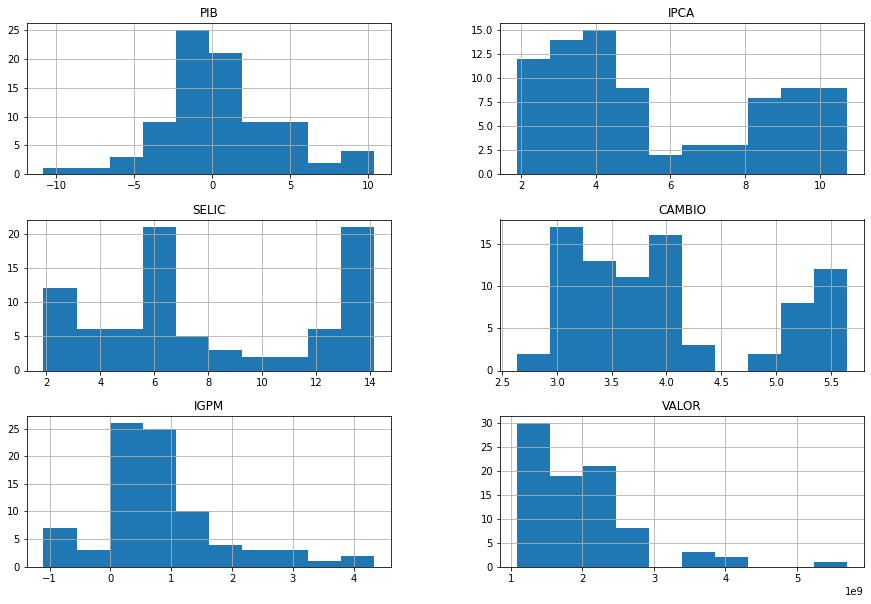

In [12]:
#Analisando a distribuição dos dados com Historiograma
varmacroarrecad_15_21.hist(figsize=(15,10))
plt.show()

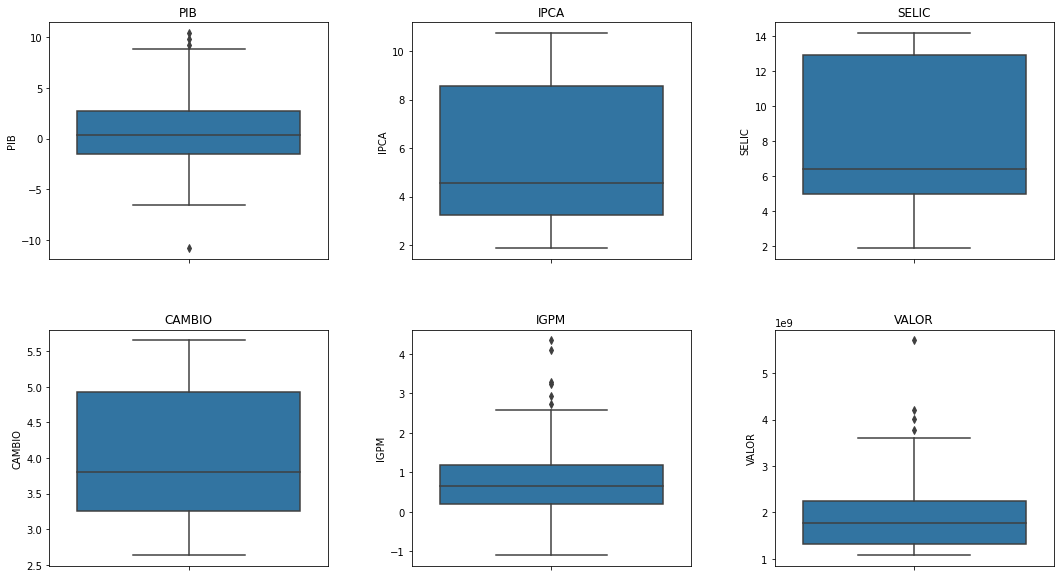

In [13]:
#Analisando a distribuição dos dados com Boxplot
import seaborn as sns
col = ['PIB',	'IPCA',	'SELIC',	'CAMBIO',	'IGPM',	'VALOR']

fig, axs = plt.subplots(2, 3, figsize=(18,10))
fig.subplots_adjust(hspace = .3, wspace = .3)
axs = axs.ravel()

for i in range(len(axs)):
  sns.boxplot(y=col[i], data=varmacroarrecad_15_21, ax=axs[i], showfliers=True)
  axs[i].set_title(col[i])
plt.show()

In [14]:
#Identificando os Outliers apontados pelo Boxplot
outliers1 = pd.merge(varmacroarrecad_15_21.query('IGPM > 2.7')['IGPM'],
                    varmacroarrecad_15_21.query('PIB > 8.3')['PIB'],
                     how='outer', on='DATA')
outliers2 = pd.merge(varmacroarrecad_15_21.query('PIB < -7')['PIB'],
                    varmacroarrecad_15_21.query('VALOR > 3700000000')['VALOR'],
                    how='outer', on='DATA')

outliers = pd.concat([outliers1, outliers2])
outliers.fillna('-', inplace=True)
outliers = outliers.sort_values(by='DATA')
print('VALORES IDENTIFICADOS COMO OUTLIERS:')
outliers

VALORES IDENTIFICADOS COMO OUTLIERS:


,IGPM,PIB,VALOR
DATA,,,
2015-03-01,-,10.400,-
2017-03-01,-,9.800,-
2017-11-01,-,-,5705095119.620
2017-12-01,-,-,4196062455.570
2018-01-01,-,-,4002914370.590
2018-03-01,-,9.200,-
2020-04-01,-,-10.800,-
2020-08-01,2.740,-,-
2020-09-01,4.340,-,-


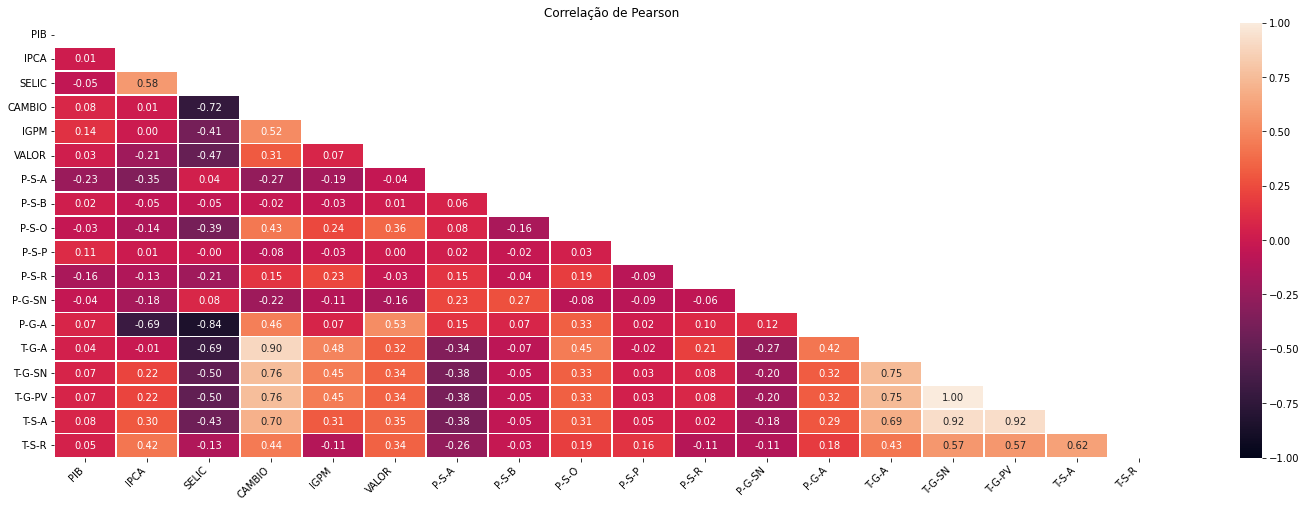

In [15]:
#Análise da correlação entre todos os atributos

#Criando um único dataframe com todos os dados
dau_15_21 = pd.merge(varmacroarrecad_15_21, data_parc_trans, how='inner',
                     on='DATA')

#Elaborando heatmap para apresentação da correlação
fig, axs = plt.subplots(1,1, figsize=(25, 8), sharey=False)
fig.subplots_adjust(hspace=.5, wspace=1.35)

dados = dau_15_21
corr = dados.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, vmax=1, vmin=-1, annot=True, square=False, 
            fmt=".2f", linewidths=.5, ax = axs)

axs.set_title("Correlação de Pearson")
axs.set_xticklabels(axs.get_xticklabels(), rotation = 45,ha="right")

plt.show()



---

**MODELOS DE MACHINE LEARNING**

In [16]:
#Criando DataFrame contendo apenas os atributos que serão usados no modelo
atributos = pd.DataFrame()
atributos = dau_15_21.drop(columns='VALOR')

#Exibindo as 5 primeiras linhas para verificação
atributos.head()

,PIB,IPCA,SELIC,CAMBIO,IGPM,P-S-A,P-S-B,P-S-O,P-S-P,P-S-R,P-G-SN,P-G-A,T-G-A,T-G-SN,T-G-PV,T-S-A,T-S-R
DATA,,,,,,,,,,,,,,,,,
2015-01-01,-5.300,7.140,11.820,2.634,0.760,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2015-02-01,-1.600,7.700,12.150,2.817,0.270,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2015-03-01,10.400,8.130,12.580,3.139,0.980,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2015-04-01,-3.600,8.170,12.680,3.043,1.170,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2015-05-01,-1.000,8.470,13.150,3.062,0.410,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [17]:
#Normalizando os valores dos atributos de entrada

#Gerando novo padrão
scaler = MinMaxScaler().fit(atributos)
atributos_normal = scaler.transform(atributos)

print('Variáveis: ', atributos_normal.shape)
print(atributos_normal)

Variáveis:  (84, 17)
[[0.25943396 0.59367946 0.80979592 ... 0.         0.         0.        ]
 [0.43396226 0.65688488 0.83673469 ... 0.         0.         0.        ]
 [1.         0.70541761 0.87183673 ... 0.         0.         0.        ]
 ...
 [0.52830189 0.99209932 0.35918367 ... 1.         1.         1.        ]
 [0.62735849 1.         0.46938776 ... 1.         1.         1.        ]
 [0.6509434  0.92325056 0.56       ... 1.         1.         1.        ]]


In [18]:
#Setando as variáveis de predição
x = atributos_normal

#Setando a variável alvo
y = arrecad_15_21["VALOR"]

1º MODELO: Regressão Linear

-- Regressão Linear --
Erro médio: 342584890.21
Coeficiente de determinação: 52.28



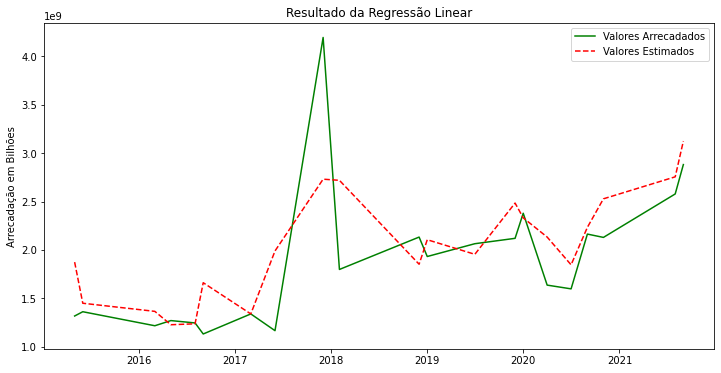

In [19]:
#1º MODELO
#Regressão Linear

#Instanciando o modelo
lr = linear_model.LinearRegression()

#Dividindos as bases de treino e de teste
treino_x, val_x, treino_y, val_y = train_test_split(x, y, random_state=4)

#Treinando o modelo com a carga de treino
lr.fit(treino_x, treino_y)

#Realizando a previsão com a carga de teste
pred_lr = lr.predict(val_x)

print('-- Regressão Linear --')

#Quantificando o erro médio
print(f'Erro médio: {mean_absolute_error(val_y, pred_lr):.2f}')

#Apurando Coeficiente R2
cd_lr = r2_score(val_y, pred_lr)
print(f'Coeficiente de determinação: {cd_lr * 100:.2f}')
print()

#Apresentando o resultado graficamente

#Gerando um DataFrame com os valores reais e os valores previsto pelo modelo
result_lr = pd.DataFrame(val_y)
result_lr['ESTIMADO'] = pred_lr
result_lr.sort_values(by='DATA', inplace=True)

#Gerando gráfico sobrepondo os valores reais e os previstos
plt.figure(figsize=(12, 6))
plt.title('Resultado da Regressão Linear')
plt.ylabel('Arrecadação em Bilhões')
plt.plot(result_lr['VALOR'], color='green', label='Valores Arrecadados')
plt.plot(result_lr['ESTIMADO'], 'k--', color='red', label='Valores Estimados')
plt.legend(loc='upper right')
plt.show()

2º MODELO: Árvore de Decisão

-- Árvore de Decisão --
Erro médio: 154679944.13
Coeficiente de determinação: 91.15



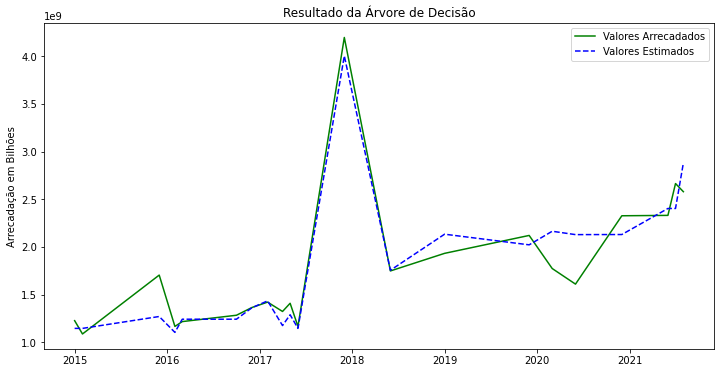

In [20]:
#2º MODELO
#Árvore de Decisão

#Instanciando o modelo
dt = DecisionTreeRegressor(random_state=5)

#Dividindos as bases de treino e de teste
treino_x, val_x, treino_y, val_y = train_test_split(x, y, random_state=2)

#Treinando o modelo com a carga de treino
dt.fit(treino_x, treino_y)

#Realizando a previsão com a carga de teste
pred_dt = dt.predict(val_x)

print('-- Árvore de Decisão --')

#Quantificando o erro médio
print(f'Erro médio: {mean_absolute_error(val_y, pred_dt):.2f}')
cd_dt = r2_score(val_y, pred_dt)
print(f'Coeficiente de determinação: {cd_dt * 100:.2f}')
print()

#Apresentando o resultado graficamente

#Gerando um DataFrame com os valores reais e os valores previsto pelo modelo
result_dt = pd.DataFrame(val_y)
result_dt['ESTIMADO'] = pred_dt
result_dt.sort_values(by='DATA', inplace=True)

#Gerando gráfico sobrepondo os valores reais e os previstos
plt.figure(figsize=(12, 6))
plt.title('Resultado da Árvore de Decisão')
plt.ylabel('Arrecadação em Bilhões')
plt.plot(result_dt['VALOR'], color='green', label='Valores Arrecadados')
plt.plot(result_dt['ESTIMADO'], 'k--', color='blue', label='Valores Estimados')
plt.legend(loc='upper right')
plt.show()

In [21]:
#Avaliando graus de erros com diferentes profundidades de árvores de decisão
def get_mae (folhas_max, treino_x, val_x, treino_y, val_y):
  modelo = DecisionTreeRegressor(max_leaf_nodes=folhas_max, random_state=5)
  modelo.fit(treino_x, treino_y)
  prev = modelo.predict(val_x)
  mae = mean_absolute_error(val_y, prev)
  return mae

#Rodando um loop para testar diferentes tamanhos máximos de folhas
for maximo_folhas in [5, 10, 15, 20, 25, 30, 35]:
  mae_dau = get_mae(maximo_folhas, treino_x, val_x, treino_y, val_y)
  print("Máximo de folhas: %d  \t\t Erro médio:  %f" %(maximo_folhas, mae_dau))

Máximo de folhas: 5  		 Erro médio:  216575343.870148
Máximo de folhas: 10  		 Erro médio:  192130705.328069
Máximo de folhas: 15  		 Erro médio:  148456767.163630
Máximo de folhas: 20  		 Erro médio:  161574515.340303
Máximo de folhas: 25  		 Erro médio:  165619983.698880
Máximo de folhas: 30  		 Erro médio:  159050545.739228
Máximo de folhas: 35  		 Erro médio:  158464306.473684


O número de folhas máximo que apresenta o menor erro médio é: 16

-- Árvore de Decisão Aprimorada --
Erro médio de:  144108108.24205825
Coeficiente de determinação: 93.23



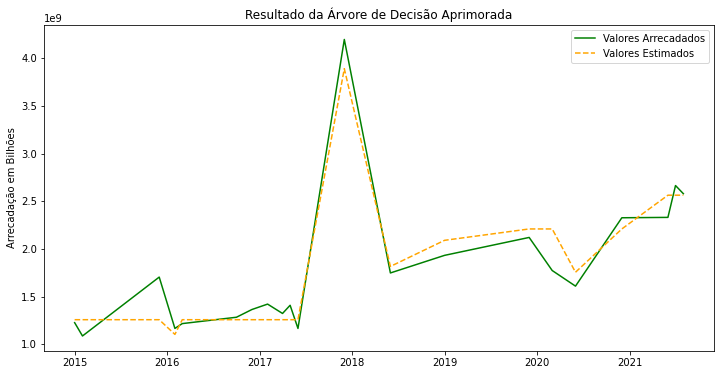

In [22]:
#Criando loop para encontrar o melhor dimensionamento de profundidade, 
#com base nos resultados do teste anterior
scores = {leaf_size: get_mae(leaf_size, treino_x, val_x, treino_y, val_y) for 
          leaf_size in range(2, 40, 1)}
print("O número de folhas máximo que apresenta o menor erro médio é:", 
      min(scores, key=scores.get))

#Gerando nova previsão com o número de folha mais eficiente
dt = DecisionTreeRegressor(max_leaf_nodes=min(scores, key=scores.get), 
                           random_state=5)
dt.fit(treino_x, treino_y)
pred_dt_up = dt.predict(val_x)

print()
print('-- Árvore de Decisão Aprimorada --')

#Quantificando o erro médio
print("Erro médio de: ", get_mae(min(scores, key=scores.get), treino_x, val_x, 
                                 treino_y, val_y))
cd_dt_up = r2_score(val_y, pred_dt_up)
print(f'Coeficiente de determinação: {cd_dt_up * 100:.2f}')
print()

#Apresentando novo resultado graficamente

#Gerando um DataFrame com os valores reais e os valores previsto pelo modelo
result_dt_up = pd.DataFrame(val_y)
result_dt_up['ESTIMADO'] = pred_dt_up
result_dt_up.sort_values(by='DATA', inplace=True)

#Gerando gráfico sobrepondo os valores reais e os previstos
plt.figure(figsize=(12, 6))
plt.title('Resultado da Árvore de Decisão Aprimorada')
plt.ylabel('Arrecadação em Bilhões')
plt.plot(result_dt_up['VALOR'], color='green', label='Valores Arrecadados')
plt.plot(result_dt_up['ESTIMADO'], 'k--', color='orange', label='Valores '+ \
         'Estimados')
plt.legend(loc='upper right')
plt.show()

3º MODELO: Floresta Randômica

-- Floresta Randômica --
Erro médio: 182803733.70
Coeficiente de determinação: 82.70



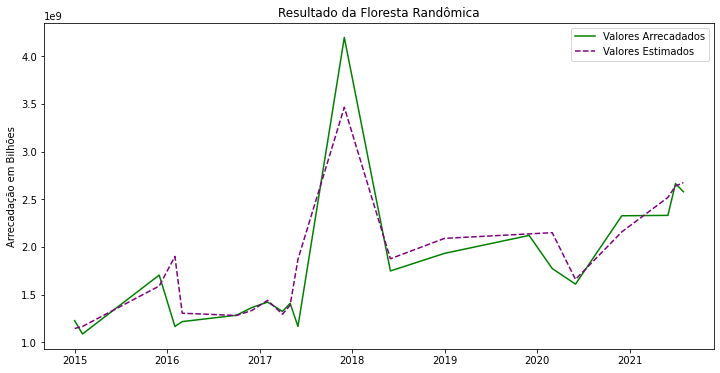

In [23]:
#3º MODELO
#Floresta Randômica

#Instanciando o modelo
rf = RandomForestRegressor(random_state=5)

#Dividindos as bases de treino e de teste
treino_x, val_x, treino_y, val_y = train_test_split(x, y, random_state=2)

#Treinando o modelo com a carga de treino
rf.fit(treino_x, treino_y)

#Realizando a previsão com a carga de teste
pred_rf = rf.predict(val_x)

print('-- Floresta Randômica --')

#Quantificando o erro médio
print(f'Erro médio: {mean_absolute_error(val_y, pred_rf):.2f}')
cd_rf = r2_score(val_y, pred_rf)
print(f'Coeficiente de determinação: {cd_rf * 100:.2f}')
print()

#Apresentando novo resultado graficamente

#Gerando um DataFrame com os valores reais e os valores previsto pelo modelo
result_rf = pd.DataFrame(val_y)
result_rf['ESTIMADO'] = pred_rf
result_rf.sort_values(by='DATA', inplace=True)

#Gerando gráfico sobrepondo os valores reais e os previstos
plt.figure(figsize=(12, 6))
plt.title('Resultado da Floresta Randômica')
plt.ylabel('Arrecadação em Bilhões')
plt.plot(result_rf['VALOR'], color='green', label='Valores Arrecadados')
plt.plot(result_rf['ESTIMADO'], 'k--', color='purple', label='Valores '+ \
         'Estimados')
plt.legend(loc='upper right')
plt.show()

In [24]:
#Avaliando graus de erros com diferentes profundidades de árvores de decisão
#para a Floresta Randômica
def get_mae_rf (folhas_max, treino_x, val_x, treino_y, val_y):
  modelo = RandomForestRegressor(max_leaf_nodes=folhas_max, random_state=5)
  modelo.fit(treino_x, treino_y)
  prev = modelo.predict(val_x)
  mae = mean_absolute_error(val_y, prev)
  return mae

#Rodando um loop para testar diferentes tamanhos máximos de folhas
for maximo_folhas in [5, 10, 15, 20, 25, 30, 35, 40]:
  mae_dau = get_mae_rf(maximo_folhas, treino_x, val_x, treino_y, val_y)
  print("Máximo de folhas: %d  \t\t Erro médio:  %f" %(maximo_folhas, mae_dau))

Máximo de folhas: 5  		 Erro médio:  212697411.648668
Máximo de folhas: 10  		 Erro médio:  200651585.477326
Máximo de folhas: 15  		 Erro médio:  190279948.555709
Máximo de folhas: 20  		 Erro médio:  186204068.279273
Máximo de folhas: 25  		 Erro médio:  183961274.636008
Máximo de folhas: 30  		 Erro médio:  183218263.898435
Máximo de folhas: 35  		 Erro médio:  182881238.609508
Máximo de folhas: 40  		 Erro médio:  182848418.280157


O número de folhas máximo que apresenta o menor erro médio é: 36

-- Floresta Randômica Aprimorada --
Erro médio de:  182831438.49776226
Coeficiente de determinação: 83.07



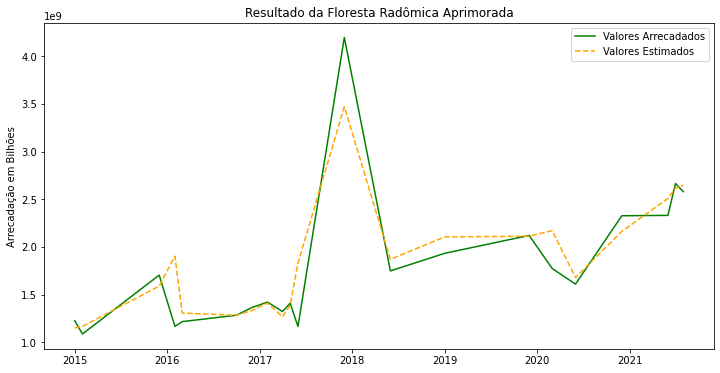

In [25]:
#Criando loop para encontrar o melhor dimensionamento de profundidade, 
#com base nos resultados do teste anterior
scores = {leaf_size: get_mae_rf(leaf_size, treino_x, val_x, treino_y, val_y) for 
          leaf_size in range(20, 45, 1)}
print("O número de folhas máximo que apresenta o menor erro médio é:", 
      min(scores, key=scores.get))

#Gerando nova previsão com o número de folha mais eficiente
rf_up = RandomForestRegressor(max_leaf_nodes=min(scores, key=scores.get), 
                           random_state=5)
rf_up.fit(treino_x, treino_y)
pred_rf_up = rf_up.predict(val_x)

print()
print('-- Floresta Randômica Aprimorada --')

#Quantificando o erro médio
print("Erro médio de: ", get_mae_rf(min(scores, key=scores.get), treino_x, 
                                    val_x, treino_y, val_y))
cd_rf_up = r2_score(val_y, pred_rf_up)
print(f'Coeficiente de determinação: {cd_rf_up * 100:.2f}')
print()

#Apresentando novo resultado graficamente

#Gerando um DataFrame com os valores reais e os valores previsto pelo modelo
result_rf_up = pd.DataFrame(val_y)
result_rf_up['ESTIMADO'] = pred_rf_up
result_rf_up.sort_values(by='DATA', inplace=True)

#Gerando gráfico sobrepondo os valores reais e os previstos
plt.figure(figsize=(12, 6))
plt.title('Resultado da Floresta Radômica Aprimorada')
plt.ylabel('Arrecadação em Bilhões')
plt.plot(result_rf_up['VALOR'], color='green', label='Valores Arrecadados')
plt.plot(result_rf_up['ESTIMADO'], 'k--', color='orange', label='Valores '+ \
         'Estimados')
plt.legend(loc='upper right')
plt.show()

4º MODELO: Árvore de Decisão de Aumento de Gradiente

-- Árvore de Decisão de Aumento de Gradiente --
Erro médio: 117905245.46
Coeficiente de determinação: 94.27



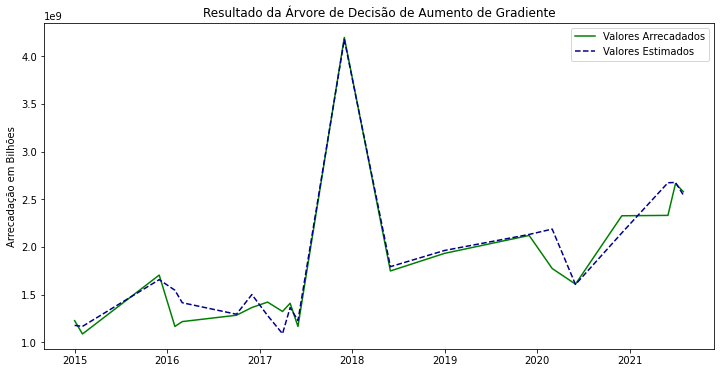

In [26]:
#4º MODELO
#Árvore de Decisão de Aumento de Gradiente

#Instanciando o modelo
gtb = GradientBoostingRegressor(random_state=5)

#Dividindos as bases de treino e de teste
treino_x, val_x, treino_y, val_y = train_test_split(x, y, random_state=2)

#Treinando o modelo com a carga de treino
gtb.fit(treino_x, treino_y)

#Realizando a previsão com a carga de teste
pred_gtb = gtb.predict(val_x)

print('-- Árvore de Decisão de Aumento de Gradiente --')

#Quantificando o erro médio
print(f'Erro médio: {mean_absolute_error(val_y, pred_gtb):.2f}')
cd_gtb = r2_score(val_y, pred_gtb)
print(f'Coeficiente de determinação: {cd_gtb * 100:.2f}')
print()

#Apresentando novo resultado graficamente

#Gerando um DataFrame com os valores reais e os valores previsto pelo modelo
result_gtb = pd.DataFrame(val_y)
result_gtb['ESTIMADO'] = pred_gtb
result_gtb.sort_values(by='DATA', inplace=True)

#Gerando gráfico sobrepondo os valores reais e os previstos
plt.figure(figsize=(12, 6))
plt.title('Resultado da Árvore de Decisão de Aumento de Gradiente')
plt.ylabel('Arrecadação em Bilhões')
plt.plot(result_gtb['VALOR'], color='green', label='Valores Arrecadados')
plt.plot(result_gtb['ESTIMADO'], 'k--', color='darkblue', label='Valores '+ \
         'Estimados')
plt.legend(loc='upper right')
plt.show()

In [27]:
#Avaliando graus de erros com diferentes estágios de reforço das árvores de 
#decisão para Gradient boosting
def get_mae_gtb (estimator_max, treino_x, val_x, treino_y, val_y):
  modelo = GradientBoostingRegressor(n_estimators=estimator_max, random_state=5)
  modelo.fit(treino_x, treino_y)
  prev = modelo.predict(val_x)
  mae = mean_absolute_error(val_y, prev)
  return mae

#Rodando um loop para testar diferentes tamanhos máximos de folhas
for maximo_estim in [35, 40, 45, 50, 55, 60, 65, 70]:
  mae_dau = get_mae_gtb(maximo_estim, treino_x, val_x, treino_y, val_y)
  print("Máximo de Estimativas: %d  \t\t Erro médio:  %f" %(maximo_estim, 
                                                            mae_dau))

Máximo de Estimativas: 35  		 Erro médio:  128212723.304237
Máximo de Estimativas: 40  		 Erro médio:  119726194.571219
Máximo de Estimativas: 45  		 Erro médio:  120101023.930660
Máximo de Estimativas: 50  		 Erro médio:  119249099.928193
Máximo de Estimativas: 55  		 Erro médio:  118738890.904800
Máximo de Estimativas: 60  		 Erro médio:  118529126.939991
Máximo de Estimativas: 65  		 Erro médio:  118428866.139754
Máximo de Estimativas: 70  		 Erro médio:  119206776.593646


O número de estimativas máximo que apresenta o menor erro médio é: 62

-- Árvore de Decisão de Aumento de Gradiente Aprimorada --
Erro médio: 117320076.32
Coeficiente de determinação: 94.76



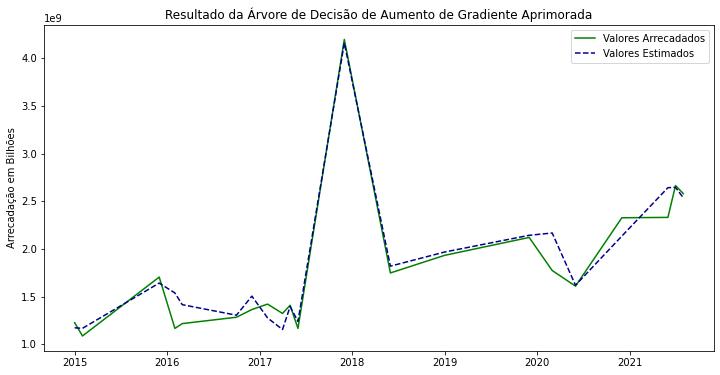

In [28]:
#Criando loop para encontrar o melhor dimensionamento de estimativas, 
#com base nos resultados do teste anterior
scores = {estim_size: get_mae_gtb(estim_size, treino_x, val_x, treino_y, val_y) for 
          estim_size in range(35, 70, 1)}
print("O número de estimativas máximo que apresenta o menor erro médio é:", 
      min(scores, key=scores.get))

#Gerando nova previsão com o número de folha mais eficiente
gtb_up = GradientBoostingRegressor(n_estimators=min(scores, key=scores.get), 
                           random_state=5)
gtb_up.fit(treino_x, treino_y)
pred_gtb_up = gtb_up.predict(val_x)

print()
print('-- Árvore de Decisão de Aumento de Gradiente Aprimorada --')

#Quantificando o erro médio
print(f'Erro médio: {mean_absolute_error(val_y, pred_gtb_up):.2f}')
cd_gtb_up = r2_score(val_y, pred_gtb_up)
print(f'Coeficiente de determinação: {cd_gtb_up * 100:.2f}')
print()

#Apresentando novo resultado graficamente

#Gerando um DataFrame com os valores reais e os valores previsto pelo modelo
result_gtb_up = pd.DataFrame(val_y)
result_gtb_up['ESTIMADO'] = pred_gtb_up
result_gtb_up.sort_values(by='DATA', inplace=True)

#Gerando gráfico sobrepondo os valores reais e os previstos
plt.figure(figsize=(12, 6))
plt.title('Resultado da Árvore de Decisão de Aumento de Gradiente Aprimorada')
plt.ylabel('Arrecadação em Bilhões')
plt.plot(result_gtb_up['VALOR'], color='green', label='Valores Arrecadados')
plt.plot(result_gtb_up['ESTIMADO'], 'k--', color='darkblue', label='Valores '+ \
         'Estimados')
plt.legend(loc='upper right')
plt.show()

In [29]:
'''Testando diferentes random_states no split das bases de treino e teste e 
também no modelo, para ver se é possível obter um coeficiente de determinação
melhor que o encontrato'''

df_resul = pd.DataFrame()

for rs in range(0, 20):
  #Dividindo massas de treino e teste
  treino_x, val_x, treino_y, val_y = train_test_split(x, y, random_state=rs)
  for mrs in range(0, 20):      
    #Modelo de regressão linear
    lr = linear_model.LinearRegression()
    lr.fit(treino_x, treino_y)
    pred = lr.predict(val_x)
    lr_mae = mean_absolute_error(val_y, pred)
    cd = r2_score(val_y, pred)
    lr_cd = cd * 100

    #Árvore de Decisão
    dt = DecisionTreeRegressor(random_state=mrs)
    dt.fit(treino_x, treino_y)
    previsao = dt.predict(val_x)
    ad_mae = mean_absolute_error(val_y, previsao)
    cd = r2_score(val_y, previsao)
    ad_cd = cd * 100

    #Árvore Randômica:
    ar = RandomForestRegressor(random_state=mrs)
    ar.fit(treino_x, treino_y)
    previsaoar = ar.predict(val_x)
    ar_mae = mean_absolute_error(val_y, previsaoar)
    cd = r2_score(val_y, previsaoar)
    ar_cd = cd * 100

    #Gradient Tree Boosting
    gtb = GradientBoostingRegressor(random_state=mrs)
    gtb.fit(treino_x, treino_y)
    previsaogtb = gtb.predict(val_x)
    gtb_mae = mean_absolute_error(val_y, previsaogtb)
    cd = r2_score(val_y, previsaogtb)
    gtb_cd = cd * 100

    base_line = 94
    condicao = lr_cd > base_line or ad_cd > base_line or +\
                ar_cd > base_line or gtb_cd > base_line

    if condicao:
      df_resul['Random_State_Split_'+str(rs)+'_Modelo_'+
               str(mrs)] = [lr_mae, lr_cd, ad_mae, ad_cd, ar_mae, ar_cd, 
                            gtb_mae, gtb_cd]

df_resul.index = ['Regressão Linear MAE:', 'Regressão Linear Coeficiente:',
                  'Árvore de Decisão MAE:', 'Árvore de Decisão Coeficiente:', 
                  'Árvore Randômica MAE:', 'Árvore Randômica Coeficiente:', 
                  'Gradient Tree Boosting MAE:', 'Gradient Tree Boosting '+ \
                  'Coeficiente:']
df_resul

,Random_State_Split_2_Modelo_5,Random_State_Split_2_Modelo_8,Random_State_Split_2_Modelo_16
Regressão Linear MAE:,567316162.883,567316162.883,567316162.883
Regressão Linear Coeficiente:,12.114,12.114,12.114
Árvore de Decisão MAE:,154679944.131,160044079.913,204070835.580
Árvore de Decisão Coeficiente:,91.154,90.630,78.090
Árvore Randômica MAE:,182803733.697,178879723.981,176857537.337
Árvore Randômica Coeficiente:,82.698,85.275,83.749
Gradient Tree Boosting MAE:,117905245.456,120049097.421,119854305.810
Gradient Tree Boosting Coeficiente:,94.265,94.088,94.185
